In [2]:
library(gridExtra)
library(matrixStats)
library(dplyr)
library(rlang)
library(reshape2)
library(clusterCrit)
library(grid)
library(ggrepel)
library(RColorBrewer)
library(dplyr)
library(IRdisplay)
library(scales)
library(survival)
library(corrplot)
library(Hmisc)
library(ggplot2)
library(survminer)
library(muhaz)
library(dplyr)
library(stringr)
library(dummies)
library(miceadds)
options(warn=-1)
library(data.table)
library(tidyr)

source('../../../../src/tools.R')     # custom tools function
source('../../../../src/hdp_tools_yanis.R')
source("../../../../src/merge_df.R")
source("../../../../src/my_toolbox.R")
source("../../../../src/my_components.R")
source("../../../../src/my_utils.R")
source("../../../../src/ggstyles.R")
source("../../../../src/my_hotspots.R")
###


theme_set(theme_minimal())

# set jupyer notebook parameters
options(repr.plot.res        = 100, # set a medium-definition resolution for the jupyter notebooks plots (DPI)
        repr.matrix.max.rows = 200, # set the maximum number of rows displayed
        repr.matrix.max.cols = 200) # set the maximum number of columns displayed


In [3]:

df_w_correlates <- read.table("full_data_validation_NO_ITD.tsv")
df_final <- read.table("full_data_validation_NO_ITD.tsv")
col_list <- c("t_15_17","inv_16","t_8_21","t_8_21_ITD","t_11","t_6_9","t_6_9_ITD","inv_3","additions","TP53_complex","NPM1","NPM1_ITD","CEBPA_bi","CEBPA_bi_ITD","DNMT3A_IDH1_2","DNMT3A_IDH1_2_ITD",
              "WT1","WT1_ITD","chr_splicing_multiple","chr_splicing_1","not_assigned","not_assigned_ITD","no_events")

# COMPONENT REPARTITION

In [29]:
png("../../../script_figures/val_comp_repartition.png",width=2500,height=2500,res=200)
cols_component <- colnames(df_final %>% dplyr:: select(starts_with("full_component_")))
df_tmp <- setNames(data.frame(matrix(ncol = length(col_list), nrow = length(col_list))), gsub("full_component_","",col_list))
rownames(df_tmp) <- gsub("full_component_","",col_list)
for (col in cols_component){
    for (col_bis in cols_component){
        df_tmp[gsub("full_component_","",col),gsub("full_component_","",col_bis)] <- ifelse(is.null(dim(df_final[df_final[,col]==1 & df_final[,col_bis]==1,])[1]),0,dim(df_final[df_final[,col]==1 & df_final[,col_bis]==1,])[1])
        }}

set_notebook_plot_size(20,12)
get_lower_tri<-function(cormat){
cormat[upper.tri(cormat)] <- NA
return(cormat)
}
# Get upper triangle of the correlation matrix
get_upper_tri <- function(cormat){
cormat[lower.tri(cormat)]<- NA
return(cormat)
}
upper_tri <- get_upper_tri(as.matrix(df_tmp))
melted_cormat <- melt(upper_tri, na.rm = TRUE)
melted_cormat <- cbind(melted_cormat, value_bis=0)
for (col in unique(melted_cormat$Var1)){
    melted_cormat[melted_cormat$Var1==col,]$value_bis <- 100*melted_cormat[melted_cormat$Var1==col,]$value / melted_cormat[melted_cormat$Var1==col & melted_cormat$Var2==col,]$value
    }
# tmp <- t(data.frame(table(df_final$final_component)))
# rownames(tmp) <- c("Final Component (HDP)","Num of Patients")
# tmp
# tmp <- t(data.frame(table(df_w_correlates$overlap)))
# rownames(tmp) <- c("Overlap","Num of Patients")
# tmp
ggplot(melted_cormat, aes(Var2, Var1, fill = value_bis))+
geom_tile(color = "white")+
scale_fill_gradient2(low = "#0072B2", high = "#009E73", mid = "#BFBFBF", 
  space = "Lab", 
name="Proportion of overlapping patients (%)") +
theme_minimal()+ # minimal theme
theme(axis.text.x = element_text(angle = 45, vjust = 1, 
size = 12, hjust = 1,face="bold"),axis.text.y = element_text( vjust = 1, 
size = 12, hjust = 1,face="bold"))+
coord_fixed()+
xlab("Component")+ylab("Component")+
geom_text(aes(Var2, Var1, label = value), color = "black", size =5) +
theme(
panel.grid.major = element_blank(),
panel.border = element_blank(),
panel.background = element_blank(),
axis.ticks = element_blank(),
legend.justification = c(2, 0),
#legend.position = c(0.6, 0.7),
legend.direction = "horizontal",
plot.title=element_text(size=25,face="bold",hjust=0.5))+
guides(fill = guide_colorbar(barwidth = 7, barheight = 1,
            title.position = "top", title.hjust = 0.5))+
ggtitle("Component Repartition NEJM Validation")
dev.off()

pdf 
  2

# SURVIVAL SPREAD COMPONENTS

In [19]:
png("../../../script_figures/val_spread_surv.png",width=4000,height=2500,res=200)
df_w_correlates <- read.table("full_data_validation_NO_ITD.tsv")
df_final <- read.table("full_data_validation_NO_ITD.tsv")
cols_component <- colnames(df_final %>% dplyr:: select(starts_with("full_component_")))
colors <- c("black","gray1","grey45", "#e79f00", "#009E73","#0072B2",  "#CC79A7",
        "#9ad0f3", "#D55E00", 
        "lightgoldenrod","lightskyblue","#F0E442",
        "firebrick3","#000000","#870C14","#a6bddb","mistyrose4","#fdbb84","gray2","deeppink","darkblue","darkred","darkgreen","purple","forestgreen")
tmp1 <- NULL
for (comp in cols_component){
    tmp2 <- df_w_correlates[df_w_correlates[,comp]==1,]
    tmp2$comparison <- comp
    tmp1 <- rbind(tmp1,tmp2)
    }

tmp2 <- df_w_correlates
tmp2$comparison <- tmp2$eln_2017
                          
tmp1 <- rbind(tmp1,tmp2)
surv_object <- Surv(time = tmp1$OS, event = tmp1$OS_Status)
fit <- survfit(surv_object ~ comparison, data = tmp1)
p <- ggsurvplot(fit,  pval = TRUE,main = "Survival curve",risk.table=T,submain = "Kaplan-Meier estimates NEJM",palette=colors,linetype=c(1,1,rep(3,16),1),xlim=c(0,12.4),break.time.by=3,
                  ggtheme = theme_survminer(
                 font.main = c(16, "bold", "darkblue"),
                 font.submain = c(15, "bold.italic", "purple"),
                 font.caption = c(14, "plain", "orange"),
                 font.x = c(14, "bold.italic", "red"),
                 font.y = c(14, "bold.italic", "darkred"),
                 font.tickslab = c(12, "plain", "darkgreen")))

set_notebook_plot_size(20,12)
# p$plot
p$plot + ggplot2::annotate("text", 
                                x = c(10.9,7.4,7,8.7,9,12.3,11,12.4,12.2,12.2,12.2),y=c(0.06,0.09,0.22,0.2,0.22,0.73,0.68,0.67,0.5,0.38,0.21),
                                label = c("TP53_complex","inv_3","t_6_9","additions","chr_splicing_multiple","inv_16","CEBPA_bi","t_15_17","Favorable ELN","Intermediate ELN","Adverse ELN"), size = 5)
dev.off()
set_notebook_plot_size(20,6)
png("../../../script_figures/val_spread_surv_table.png",width=2000,height=2500,res=200)
p$table
dev.off()

pdf 
  2

pdf 
  2

In [25]:
cols_component <- colnames(df_final %>% dplyr:: select(starts_with("full_component_")))
binary_correlates <- c("Gender")
continuous_correlates <- c("Age","WBC","HB","PLT","BM_Blasts")
set_notebook_plot_size(30,2)

v=c("0" = "grey45", "1" = "#e79f00", "2" = "#009E73", "3" ="#0072B2", "4"="#CC79A7")
tmp <- NULL
for (comp in cols_component){
    tmp1 <- df_w_correlates[df_w_correlates[,comp]==1,]
    tmp1$comparison <- str_remove(comp,"full_component_")
    tmp <- rbind(tmp,tmp1)
    }
tmp$fill_pal <- factor(tmp$comparison)
for (col in binary_correlates){
    png(paste("../../../script_figures/val_",paste(col,"_clinical.png",sep=""),sep=""),width=4500,height=1500,res=200)
    p <- ggplot(tmp, aes(factor(comparison), fill = factor(tmp[,col]))) + 
    geom_bar(position = "fill") +
    scale_y_continuous(labels = scales::percent)+
    xlab("Full Components")+scale_fill_manual(values = v)+theme(plot.title = element_text(hjust = 0.5,size=25),axis.text=element_text(size=10,face="bold"),axis.title=element_text(size=14,face="bold"))+
    labs(fill=col)
    plot(p)
    dev.off()
}
set_notebook_plot_size(30,5)
for (col in continuous_correlates){
    png(paste("../../../script_figures/val_",paste(col,"_clinical.png",sep=""),sep=""),width=4500,height=2500,res=200)
    p <- ggplot(tmp,aes(x=reorder(comparison,-tmp[,col],FUN=median),y=tmp[,col],fill=fill_pal)) +
    geom_boxplot() + 
    theme1+
    ylab(col)+xlab("Full Components")+theme(plot.title = element_text(hjust = 0.5,size=25),axis.text=element_text(size=10,face="bold"),axis.title=element_text(size=14,face="bold"))+
    scale_y_continuous(limits = quantile(tmp[,col], c(0.01, 0.99),na.rm = T))+
    scale_fill_manual(values=c("grey45", "#e79f00", "#009E73","#0072B2",  "#CC79A7",
        "#9ad0f3", "#D55E00", 
        "lightgoldenrod","lightskyblue","#F0E442",
        "firebrick3","#000000","#870C14","#a6bddb","mistyrose4","#fdbb84","gray","deeppink","darkblue","darkred","darkgreen","purple","forestgreen"),limits=levels(tmp$fill_pal))+theme(legend.position = "none")
    # set ymin to 0 (Elli's request)
    
    suppressWarnings(plot(p))
    dev.off()
    
}


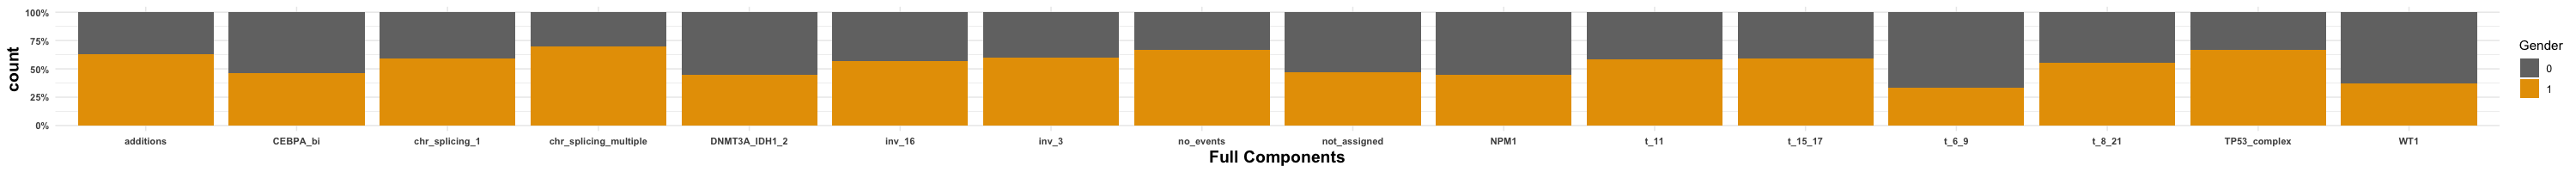

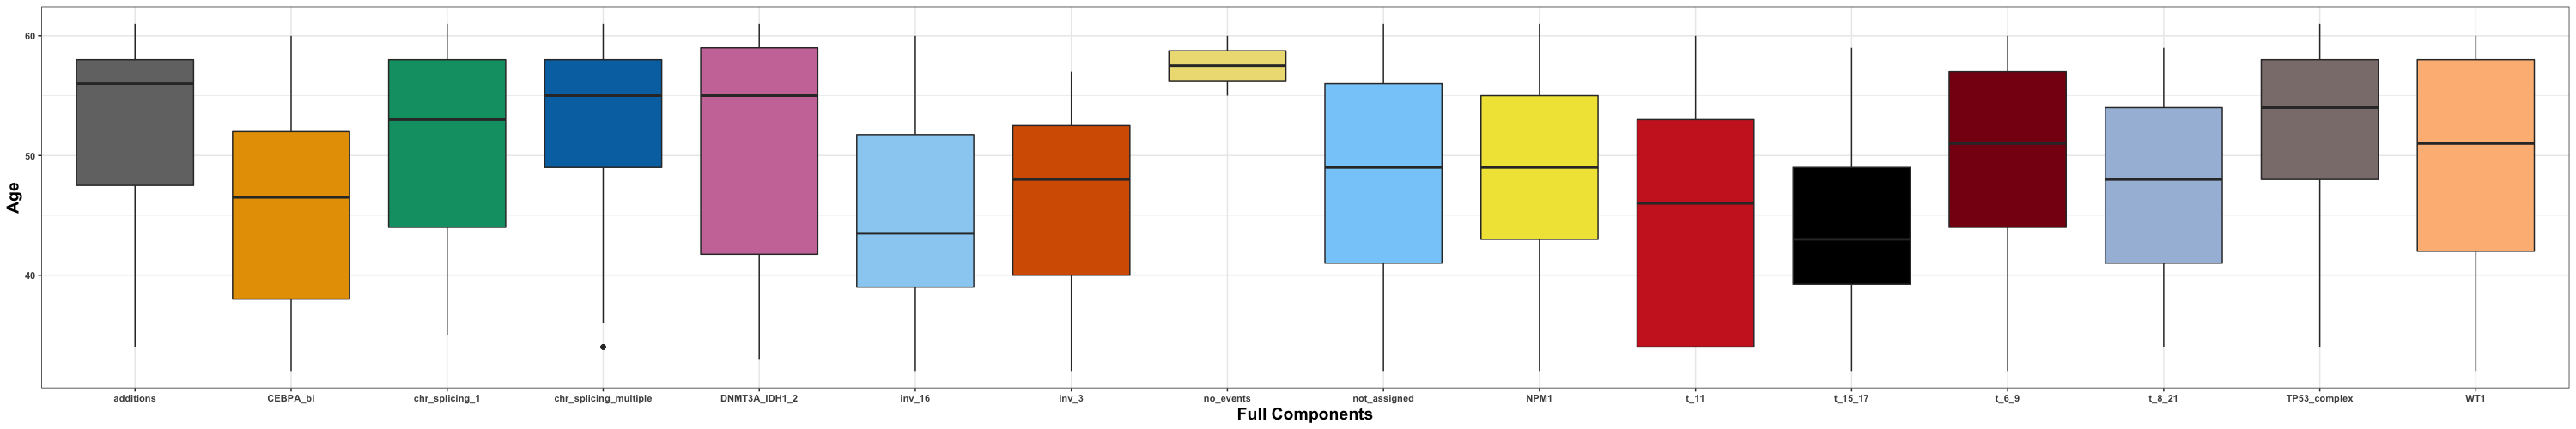

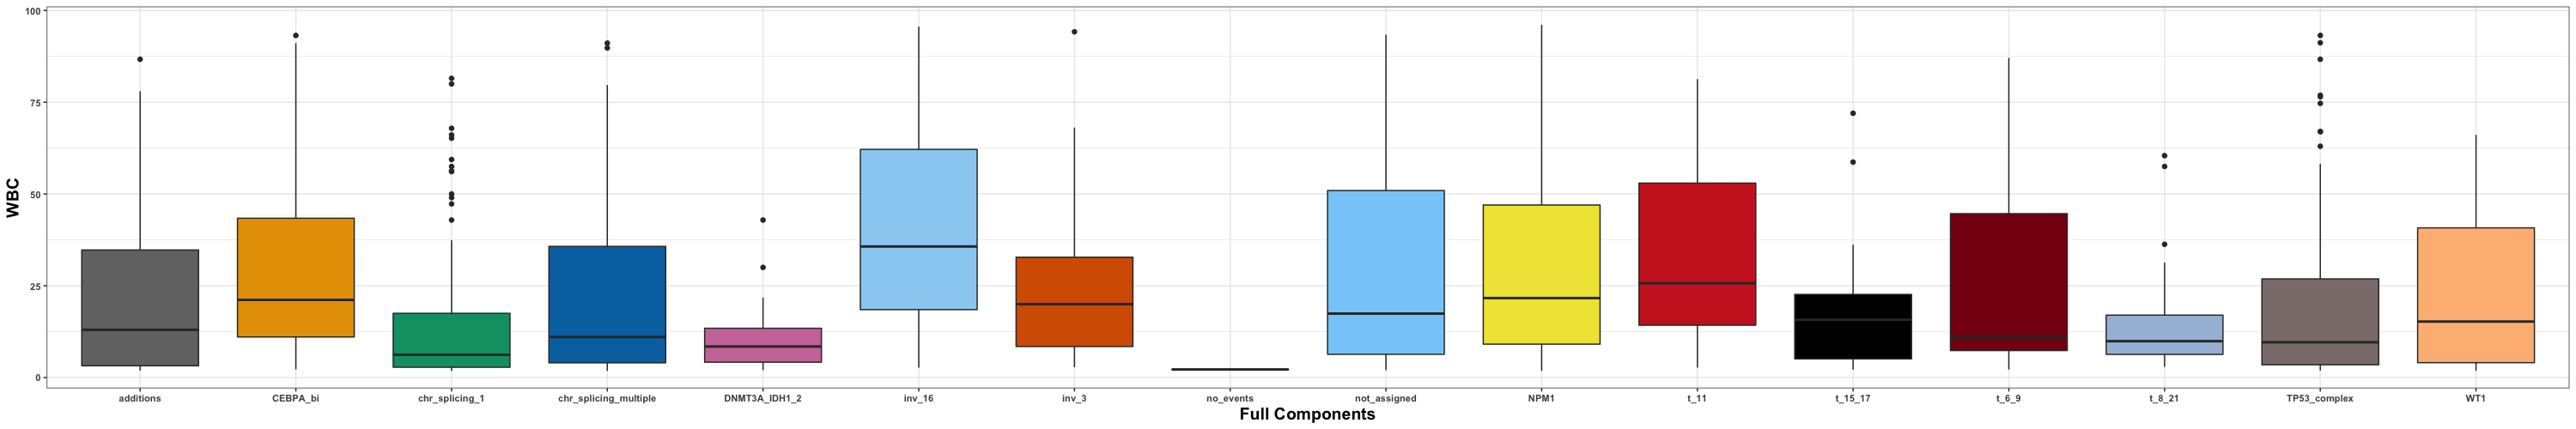

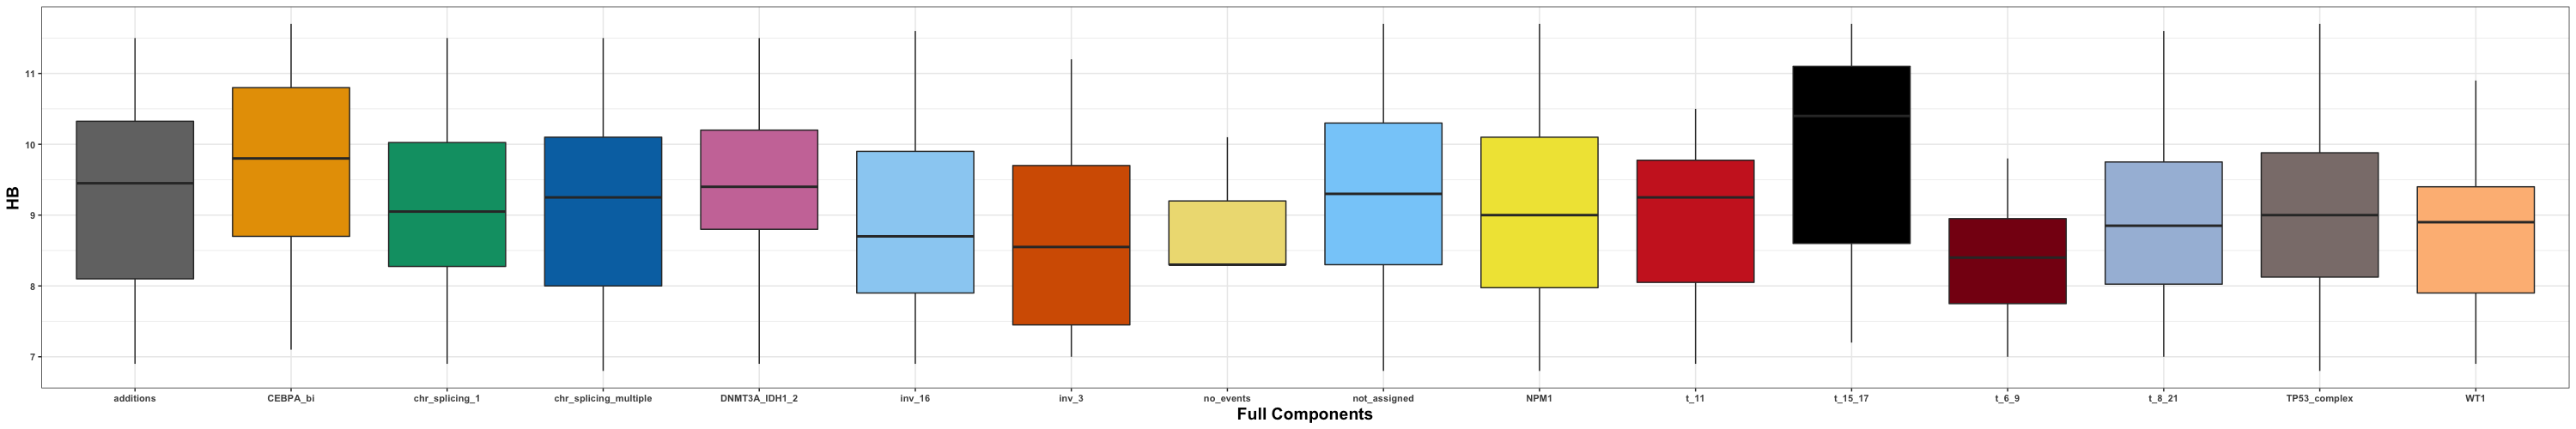

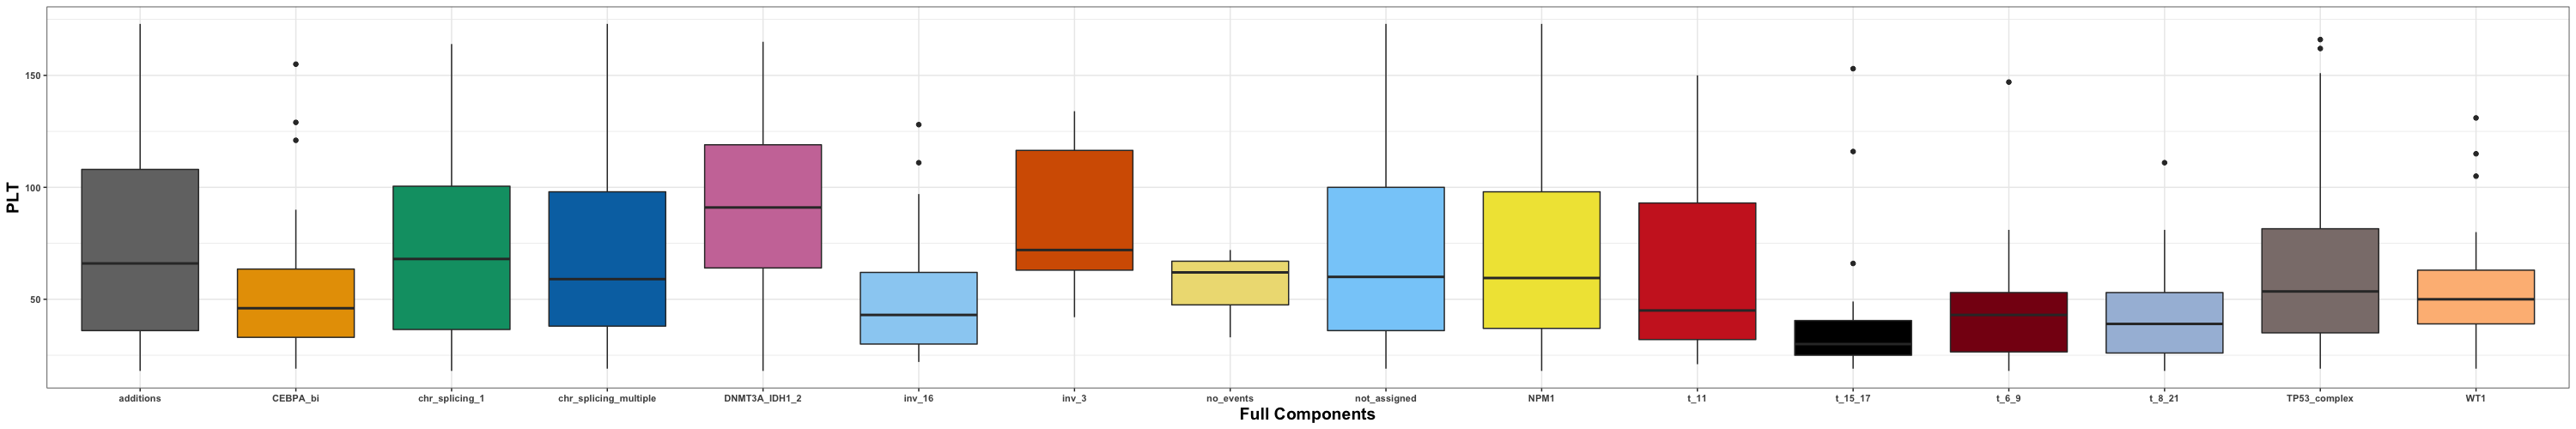

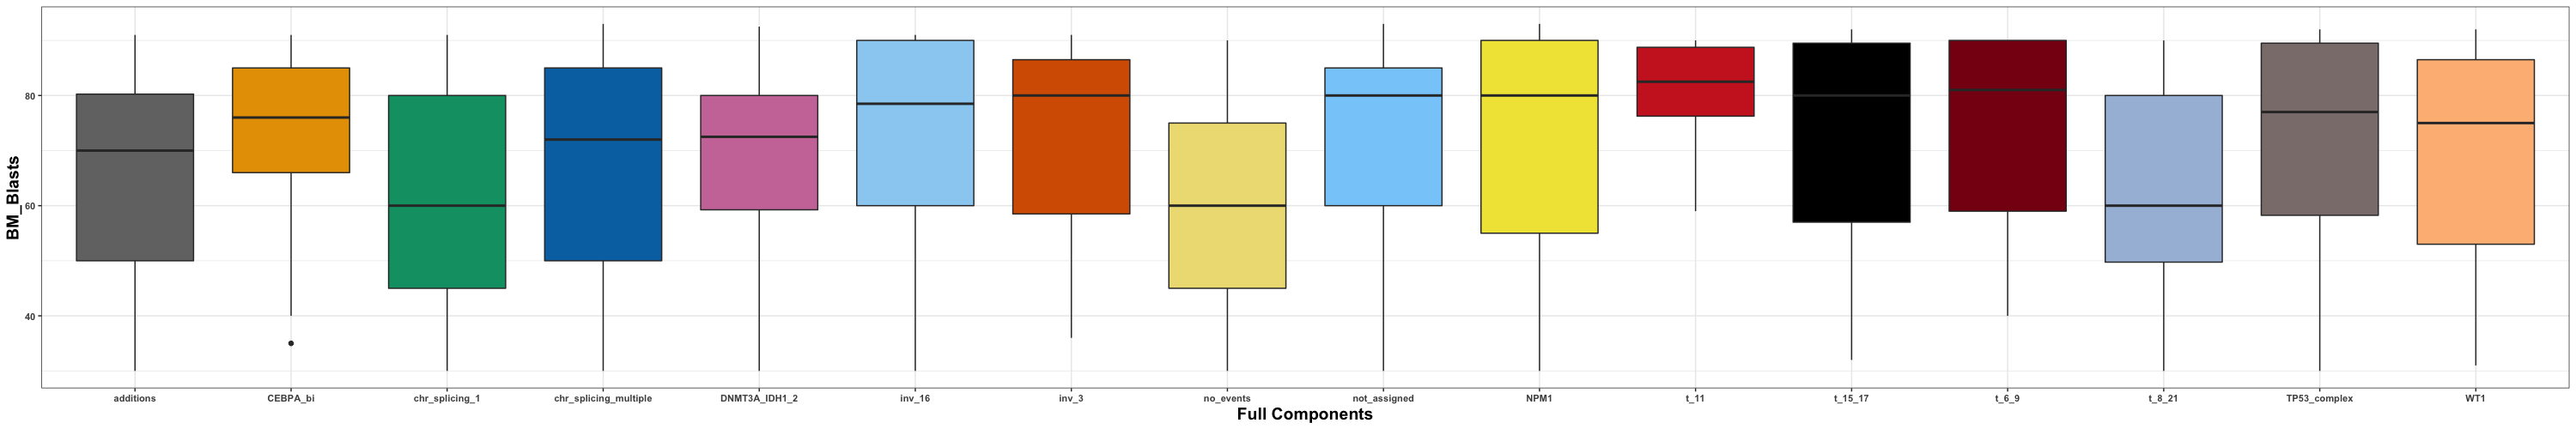

In [4]:
cols_component <- colnames(df_final %>% dplyr:: select(starts_with("full_component_")))
binary_correlates <- c("Gender")
continuous_correlates <- c("Age","WBC","HB","PLT","BM_Blasts")
set_notebook_plot_size(30,2)
# pdf(file="graphs/comparison_components_ITD.pdf",width=30,height=5)
v=c("0" = "grey45", "1" = "#e79f00", "2" = "#009E73", "3" ="#0072B2", "4"="#CC79A7")
tmp <- NULL
for (comp in cols_component){
    tmp1 <- df_w_correlates[df_w_correlates[,comp]==1,]
    tmp1$comparison <- str_remove(comp,"full_component_")
    tmp <- rbind(tmp,tmp1)
    }
tmp$fill_pal <- factor(tmp$comparison)
for (col in binary_correlates){
p <- ggplot(tmp, aes(factor(comparison), fill = factor(tmp[,col]))) + 
  geom_bar(position = "fill") +
  scale_y_continuous(labels = scales::percent)+
  xlab("Full Components")+scale_fill_manual(values = v)+theme(plot.title = element_text(hjust = 0.5,size=25),axis.text=element_text(size=8,face="bold"),axis.title=element_text(size=14,face="bold"))+
  labs(fill=col)
    plot(p)
}
set_notebook_plot_size(30,5)
for (col in continuous_correlates){
    p <- ggplot(tmp,aes(x=factor(comparison),y=tmp[,col],fill=fill_pal)) +
    geom_boxplot() + 
    theme1+
    ylab(col)+xlab("Full Components")+theme(plot.title = element_text(hjust = 0.5,size=25),axis.text=element_text(size=8,face="bold"),axis.title=element_text(size=14,face="bold"))+
    scale_y_continuous(limits = quantile(tmp[,col], c(0.1, 0.9),na.rm = T))+
    scale_fill_manual(values=c("grey45", "#e79f00", "#009E73","#0072B2",  "#CC79A7",
        "#9ad0f3", "#D55E00", 
        "lightgoldenrod","lightskyblue","#F0E442",
        "firebrick3","#000000","#870C14","#a6bddb","mistyrose4","#fdbb84","gray","deeppink","darkblue","darkred","darkgreen","purple","forestgreen"),limits=levels(tmp$fill_pal))+theme(legend.position = "none")
    # set ymin to 0 (Elli's request)
    suppressWarnings(plot(p))
    
}




# dev.off()